# Virtualized Patient Population

To-Do:
- Incorporate ICD diagnoses into problems
- Change the 2-way co-occurence relationship into a node
- Iteratively create co-occurence nodes between primary features and co-occurence nodes until no higher layers yield results that reach a signficance threshold
- Create OCCURS_WITH relationships with z-scores between continuous variables of interest
- Figure out how to add timedeltas between problems and the change in z-scores for labs or the occurrence of prescriptions

In [1]:
from datetime import datetime
from progressbar import ProgressBar
import pandas as pd
import time

In [2]:
from neo4j import GraphDatabase
driver=GraphDatabase.driver(uri="bolt://localhost:7687", auth=('neo4j','NikeshIsCool'))
session=driver.session()

Entities of interest:
- Problem
- Prescriptions -> Concept
- Labevents -> D_Labitems -> Concept
- Diagnoses_Icd -> D_Icd_Diagnoses -> Concept (timedelta of limited utility, since ICD codes pertain to entire admission)
- Procedures_Icd -> D_Icd_Procedures -> Concept (timedelta of limited utility, since ICD codes pertain to entire admission)

Relationships to create between entities of interest:
![virtualized relationships](images/Virtual_relationship_schema.png)

We'll start with these relationships to improve performance on our current use cases:  
(:Problem) - [:INSTANCE_OF] -> (:Concept) - [:OCCURS_WITH {co_occurrence_probability: __, source: 'MIMIC-III v1.4', updated: timestamp}] - (:Concept) <- [:INSTANCE_OF] - (:Prescriptions)  
(:Problem) - [:INSTANCE_OF] -> (:Concept) - [:OCCURS_WITH {co_occurrence_probability: __, z_score: __, source: 'MIMIC-III v1.4', updated: timestamp}] - (:Concept) <- [:INSTANCE_OF] - (:Labevents)  

The essential equation used to determine co-occurence probability for our purposes is:  
(Probability of A and B co-occuring during an admission) / (Probability of A + Probability of B)  

I initially considered using the probability of A given B (i.e. the conditional probability), which is:  
(Probability of A and B co-occuring during an admission) / (Probability of A occurring during an admission)  
The problem with this approach is that you get a lot of stuff that is likely to occur just because the patient is in the ICU, which has nothing to do with the given condition. For example, almost everyone in the ICU gets an IV, so medications used to flush the IVs come up as highly associated with any given condition. The co-occurence probability doesn't have this issue, so we're going with that.  
  
For labs, we calculate the probability that the lab will be flagged as abnormal, not the probability that it will be ordered. For prescriptions and procedures, we calculate the probability that they will be ordered.

## Find the probability of each individual entity of interest occurring during an admission

In [3]:
# Get the probability of each problem in the general population
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients)-[:HAD_PROBLEM]->(b:Problem)
WITH b.cui AS Problem_CUI, count(distinct(ad)) AS probTotal, ptTotal, count(distinct(Pt)) AS Pt
WITH Problem_CUI, toFloat(probTotal)/ptTotal AS Probability_Entity, Pt
WHERE Pt > 20
RETURN Problem_CUI, Probability_Entity
'''
data = session.run(query)
problem_probabilities = pd.DataFrame([dict(record) for record in data])

In [4]:
# Get the probability of each ICD diagnosis in the general population
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients)-[:HAD]->(dx:Diagnoses_Icd)
WITH dx.icd9_code AS dx_icd9_code, count(distinct(ad)) AS ProcTotal, ptTotal, count(distinct(Pt)) AS Pt
WHERE Pt > 20
RETURN dx_icd9_code, toFloat(ProcTotal)/ptTotal AS Probability_Entity
'''
data = session.run(query)
diagnosis_probabilities = pd.DataFrame([dict(record) for record in data])

In [5]:
# Get the probability of each prescription in the general population
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients)-[:HAD]-(rx:Prescriptions)-[:INSTANCE_OF]->(b:Concept)
WITH b.cui AS Rx_CUI, count(distinct(ad)) AS RxTotal, ptTotal, count(distinct(Pt)) AS Pt
WHERE Pt > 20
RETURN Rx_CUI, toFloat(RxTotal)/ptTotal AS Probability_Entity
'''
data = session.run(query)
rx_probabilities = pd.DataFrame([dict(record) for record in data])

In [6]:
# Get the probability of each abnormal lab in the general population
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients)-[:HAD]-(lab:Labevents)-[:INSTANCE_OF]->(b:Concept)
WHERE lab.flag IS NOT NULL
WITH b.cui AS Lab_CUI, count(distinct(ad)) AS LabTotal, ptTotal, count(distinct(Pt)) AS Pt
WHERE Pt > 20
RETURN Lab_CUI, toFloat(LabTotal)/ptTotal AS Probability_Entity
'''
data = session.run(query)
abnormal_lab_probabilities = pd.DataFrame([dict(record) for record in data])

In [7]:
# Get the probability of each procedure in the general population
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients)-[:HAD]->(proc:Procedures_Icd)
WITH proc.icd9_code AS procedure_icd9_code, count(distinct(ad)) AS ProcTotal, ptTotal, count(distinct(Pt)) AS Pt
WHERE Pt > 20
RETURN procedure_icd9_code, toFloat(ProcTotal)/ptTotal AS Probability_Entity
'''
data = session.run(query)
procedure_probabilities = pd.DataFrame([dict(record) for record in data])

## Find the probability of each pair of different entities of interest occuring together

In [8]:
def two_different_entities_conditional_probability_normalized(P_B_df, B_id, A_id, significance_threshold):
    
    # Calculate the co-occurance probability
    P_A_given_B_df = pd.merge(combined_entities_df, P_B_df, on=B_id)
    P_A_given_B_df['P_A_given_B'] = P_A_given_B_df.combined_entities_probability / (P_A_given_B_df.Probability_Entity)

    # Normalize the co-occurance probability using the min-max method
    P_A_given_B_df['normalized_P_A_given_B'] = (P_A_given_B_df.P_A_given_B-P_A_given_B_df.P_A_given_B.min())/(P_A_given_B_df.P_A_given_B.max()-P_A_given_B_df.P_A_given_B.min())

    # Sort the dataframe
    P_A_given_B_df.sort_values(by='normalized_P_A_given_B', ascending=False, inplace=True)
    
    # Keep only values with a conditional probability greater than a given significance threshold
    P_A_given_B_df = P_A_given_B_df[P_A_given_B_df.normalized_P_A_given_B > significance_threshold]
    
    # Write out to CSV
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = 'normalized_probability_of_'+A_id+'_given_'+B_id+'_'+timestamp+'.csv'
    P_A_given_B_df.loc[:,[B_id, A_id, 'normalized_P_A_given_B']].to_csv(filename, index=False, header=False)
    
    return 'Saved results as '+filename

In [34]:
def two_different_entities_co_occurrence_normalized(entity1_df, entity2_df, entity1_id, entity2_id, significance_threshold=0.2):
    
    # Calculate the co-occurance probability
    co_occurrence_df = pd.merge(combined_entities_df, entity1_df, on=entity1_id)
    co_occurrence_df = pd.merge(co_occurrence_df, entity2_df, on=entity2_id, suffixes=['_1', '_2'])
    co_occurrence_df['co_occurrence_probability'] = co_occurrence_df.combined_entities_probability / (co_occurrence_df.Probability_Entity_1 + co_occurrence_df.Probability_Entity_2)

    # Normalize the co-occurance probability using the min-max method
    co_occurrence_df['normalized_co_occurrence_probability'] = (co_occurrence_df.co_occurrence_probability-co_occurrence_df.co_occurrence_probability.min())/(co_occurrence_df.co_occurrence_probability.max()-co_occurrence_df.co_occurrence_probability.min())

    # Sort the dataframe
    co_occurrence_df.sort_values(by='normalized_co_occurrence_probability', ascending=False, inplace=True)
    
    # Keep only rows with a co-occurence probability greater than a given significance threshold
    co_occurrence_df = co_occurrence_df[co_occurrence_df.normalized_co_occurrence_probability > significance_threshold]
    
    # Write out to CSV
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = 'normalized_co_occurrence_probability_'+entity1_id+'_'+entity2_id+'_'+timestamp+'.csv'
    co_occurrence_df.loc[:,[entity1_id, entity2_id, 'normalized_co_occurrence_probability']].to_csv(filename, index=False, header=False)
    
    return 'Saved results as '+filename

In [63]:
# Get the probability of each pair of abnormal lab and problem
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p:Problem)<-[:HAD_PROBLEM]-(Pt)-[:HAD]->(lab:Labevents)-[:INSTANCE_OF]->(c:Concept)
WHERE lab.flag IS NOT NULL
WITH p.cui AS Problem_CUI, c.cui AS Lab_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN Problem_CUI, Lab_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=problem_probabilities, 
    entity2_df=abnormal_lab_probabilities, 
    entity1_id='Problem_CUI', 
    entity2_id='Lab_CUI')

'Saved results as normalized_co_occurrence_probability_Problem_CUI_Lab_CUI_2021-12-16_16-23-07.csv'

In [9]:
# Get the probability of each pair of prescription and problem
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p:Problem)<-[:HAD_PROBLEM]-(Pt)-[:HAD]-(rx:Prescriptions)-[:INSTANCE_OF]->(c:Concept)
WITH p.cui AS Problem_CUI, c.cui AS Rx_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN Problem_CUI, Rx_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=problem_probabilities, 
    entity2_df=rx_probabilities, 
    entity1_id='Problem_CUI', 
    entity2_id='Rx_CUI')

'Saved results as normalized_probability_of_Rx_CUI_given_Problem_CUI_2022-01-27_06-49-01.csv'

In [35]:
# Get the probability of each pair of procedure and problem
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p:Problem)<-[:HAD_PROBLEM]-(Pt)-[:HAD]->(proc:Procedures_Icd)
WITH p.cui AS Problem_CUI, proc.icd9_code AS procedure_icd9_code, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN Problem_CUI, procedure_icd9_code, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=problem_probabilities, 
    entity2_df=procedure_probabilities, 
    entity1_id='Problem_CUI', 
    entity2_id='procedure_icd9_code')

'Saved results as normalized_co_occurrence_probability_Problem_CUI_procedure_icd9_code_2022-01-08_13-45-53.csv'

In [12]:
# Get the probability of each pair of ICD diagnosis and problem
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p:Problem)<-[:HAD_PROBLEM]-(Pt)-[:HAD]->(dx:Diagnoses_Icd)
WITH p.cui AS Problem_CUI, dx.icd9_code AS dx_icd9_code, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN Problem_CUI, dx_icd9_code, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=problem_probabilities, 
    entity2_df=diagnosis_probabilities, 
    entity1_id='Problem_CUI', 
    entity2_id='dx_icd9_code')

'Saved results as normalized_co_occurrence_probability_Problem_CUI_dx_icd9_code_2022-01-08_10-59-40.csv'

In [14]:
# Get the probability of each pair of ICD diagnosis and abnormal lab
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (dx:Diagnoses_Icd)<-[:HAD]-(Pt)-[:HAD]->(lab:Labevents)-[:INSTANCE_OF]->(c:Concept)
WHERE lab.flag IS NOT NULL
WITH dx.icd9_code AS dx_icd9_code, c.cui AS Lab_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN dx_icd9_code, Lab_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=diagnosis_probabilities, 
    entity2_df=abnormal_lab_probabilities, 
    entity1_id='dx_icd9_code', 
    entity2_id='Lab_CUI')

'Saved results as normalized_co_occurrence_probability_dx_icd9_code_Lab_CUI_2022-01-08_13-16-29.csv'

In [36]:
# Get the probability of each pair of procedure and abnormal lab
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (proc:Procedures_Icd)<-[:HAD]-(Pt)-[:HAD]->(lab:Labevents)-[:INSTANCE_OF]->(c:Concept)
WHERE lab.flag IS NOT NULL
WITH proc.icd9_code AS procedure_icd9_code, c.cui AS Lab_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN procedure_icd9_code, Lab_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=procedure_probabilities, 
    entity2_df=abnormal_lab_probabilities, 
    entity1_id='procedure_icd9_code', 
    entity2_id='Lab_CUI')

'Saved results as normalized_co_occurrence_probability_procedure_icd9_code_Lab_CUI_2022-01-08_13-48-13.csv'

In [13]:
# Get the probability of each pair of procedure and prescription
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (proc:Procedures_Icd)<-[:HAD]-(Pt)-[:HAD]-(rx:Prescriptions)-[:INSTANCE_OF]->(c:Concept)
WITH proc.icd9_code AS procedure_icd9_code, c.cui AS Rx_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN procedure_icd9_code, Rx_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=procedure_probabilities, 
    entity2_df=rx_probabilities, 
    entity1_id='procedure_icd9_code', 
    entity2_id='Rx_CUI')

'Saved results as normalized_co_occurrence_probability_icd9_code_Rx_CUI_2021-12-17_08-54-58.csv'

In [24]:
# Get the probability of each pair of ICD diagnosis and prescription
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (dx:Diagnoses_Icd)<-[:HAD]-(Pt)-[:HAD]-(rx:Prescriptions)-[:INSTANCE_OF]->(c:Concept)
WITH dx.icd9_code AS dx_icd9_code, c.cui AS Rx_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN dx_icd9_code, Rx_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=diagnosis_probabilities, 
    entity2_df=rx_probabilities, 
    entity1_id='dx_icd9_code', 
    entity2_id='Rx_CUI')

'Saved results as normalized_co_occurrence_probability_dx_icd9_code_Rx_CUI_2022-01-08_13-31-40.csv'

In [24]:
# Get the probability of each pair of ICD diagnosis and prescription
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (dx:Diagnoses_Icd)<-[:HAD]-(Pt)-[:HAD]-(rx:Prescriptions)-[:INSTANCE_OF]->(c:Concept)
WITH dx.icd9_code AS dx_icd9_code, c.cui AS Rx_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN dx_icd9_code, Rx_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=diagnosis_probabilities, 
    entity2_df=rx_probabilities, 
    entity1_id='dx_icd9_code', 
    entity2_id='Rx_CUI')

'Saved results as normalized_co_occurrence_probability_dx_icd9_code_Rx_CUI_2022-01-08_13-31-40.csv'

In [26]:
# Get the probability of each pair of procedure and ICD diagnosis
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (proc:Procedures_Icd)<-[:HAD]-(Pt)-[:HAD]->(dx:Diagnoses_Icd)
WITH proc.icd9_code AS procedure_icd9_code, dx.icd9_code AS dx_icd9_code, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN procedure_icd9_code, dx_icd9_code, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=procedure_probabilities, 
    entity2_df=diagnosis_probabilities, 
    entity1_id='procedure_icd9_code', 
    entity2_id='dx_icd9_code')

'Saved results as normalized_co_occurrence_probability_procedure_icd9_code_dx_icd9_code_2022-01-08_13-40-55.csv'

In [7]:
# Get the probability of each pair of prescription and abnormal lab
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (c1:Concept)<-[:INSTANCE_OF]-(rx:Prescriptions)<-[:HAD]-(Pt)-[:HAD]->(lab:Labevents)-[:INSTANCE_OF]->(c2:Concept)
WHERE lab.flag IS NOT NULL
WITH c1.cui AS Rx_CUI, c2.cui AS Lab_CUI, count(distinct(ad)) AS combinedTotal, ptTotal, count(distinct(Pt)) AS Pts
WHERE Pts > 20
RETURN Rx_CUI, Lab_CUI, toFloat(combinedTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

two_different_entities_co_occurrence_normalized(
    entity1_df=rx_probabilities, 
    entity2_df=abnormal_lab_probabilities, 
    entity1_id='Rx_CUI', 
    entity2_id='Lab_CUI')

'Saved results as normalized_co_occurrence_probability_Rx_CUI_Lab_CUI_2021-12-17_09-20-27.csv'

## Find the probability of each entity of interest occuring with another of its kind (e.g. problems with problems)

In [6]:
def pair_same_entity_co_occurrence_normalized(entity_df, entity_id):
    
    entity1_id = entity_id+'_1'
    entity2_id = entity_id+'_2'
    
    # Calculate the co-occurance probability
    co_occurrence_df = pd.merge(combined_entities_df, entity_df, left_on=entity1_id, right_on=entity_id)
    
    co_occurrence_df = pd.merge(co_occurrence_df, entity_df, left_on=entity2_id, right_on=entity_id)
    co_occurrence_df['co_occurrence_probability'] = co_occurrence_df.combined_entities_probability / (co_occurrence_df.Probability_Entity_x + co_occurrence_df.Probability_Entity_y)
    
    # Drop duplicates
    co_occurrence_df['ID_pair'] = co_occurrence_df.loc[:,[entity1_id, entity2_id]].values.tolist()
    co_occurrence_df.ID_pair.apply(lambda x: x.sort())
    co_occurrence_df[[entity1_id,entity2_id]] = pd.DataFrame(co_occurrence_df.ID_pair.tolist(), index= co_occurrence_df.index)
    co_occurrence_df.drop_duplicates(subset=[entity1_id,entity2_id], inplace=True)
    
    # Normalize the co-occurance probability using the min-max method
    co_occurrence_df['normalized_co_occurrence_probability'] = (co_occurrence_df.co_occurrence_probability-co_occurrence_df.co_occurrence_probability.min())/(co_occurrence_df.co_occurrence_probability.max()-co_occurrence_df.co_occurrence_probability.min())
    
    # Sort the dataframe
    co_occurrence_df.sort_values(by='normalized_co_occurrence_probability', ascending=False, inplace=True)
    
    # Write out to CSV
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = 'normalized_co_occurrence_probability_paired_'+entity_id+'_'+timestamp+'.csv'
    co_occurrence_df.loc[:,[entity1_id, entity2_id, 'normalized_co_occurrence_probability']].to_csv(filename, index=False, header=False)
    
    return 'Saved results as '+filename

In [106]:
# Get the probability of each pair of problems co-occuring
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p1:Problem)<-[:HAD_PROBLEM]-(Pt)-[:HAD_PROBLEM]->(p2:Problem)
WHERE p1.cui <> p2.cui
WITH p1.cui AS Problem_CUI_1, p2.cui AS Problem_CUI_2, count(distinct(ad)) AS ProblemPairTotal, ptTotal
RETURN Problem_CUI_1, Problem_CUI_2, toFloat(ProblemPairTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

pair_same_entity_co_occurrence_normalized(
    entity_df = problem_probabilities,
    entity_id = 'Problem_CUI')

'Saved results as normalized_co_occurrence_probability_paired_Problem_CUI_2021-12-17_07-32-44.csv'

In [7]:
# Get the probability of each pair of abnormal lab events co-occuring
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (p1:Concept)<-[:INSTANCE_OF]-(lab1:Labevents)-[:OCCURRED_DURING]->(ad:Admissions)<-[:OCCURRED_DURING]-(lab2:Labevents)-[:INSTANCE_OF]->(p2:Concept)
WHERE lab1.flag IS NOT NULL AND lab2.flag IS NOT NULL AND p1.cui <> p2.cui
WITH p1.cui AS Lab_CUI_1, p2.cui AS Lab_CUI_2, count(distinct(ad)) AS ProblemPairTotal, ptTotal
RETURN Lab_CUI_1, Lab_CUI_2, toFloat(ProblemPairTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

pair_same_entity_co_occurrence_normalized(
    entity_df = abnormal_lab_probabilities,
    entity_id = 'Lab_CUI')

'Saved results as normalized_co_occurrence_probability_paired_Lab_CUI_2021-12-17_15-18-35.csv'

In [11]:
# Get the probability of each pair of procedures co-occuring
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p1:Procedures_Icd)<-[:HAD]-(Pt)-[:HAD]->(p2:Procedures_Icd)
WHERE p1.icd9_code <> p2.icd9_code
WITH p1.icd9_code AS procedure_icd9_code_1, p2.icd9_code AS procedure_icd9_code_2, count(distinct(ad)) AS ProblemPairTotal, ptTotal
RETURN procedure_icd9_code_1, procedure_icd9_code_2, toFloat(ProblemPairTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

pair_same_entity_co_occurrence_normalized(
    entity_df = procedure_probabilities,
    entity_id = 'procedure_icd9_code')

'Saved results as normalized_co_occurrence_probability_paired_procedure_icd9_code_2021-12-17_16-09-08.csv'

In [9]:
# Get the probability of each pair of diagnoses co-occuring
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p1:Diagnoses_Icd)<-[:HAD]-(Pt)-[:HAD]->(p2:Diagnoses_Icd)
WHERE p1.icd9_code <> p2.icd9_code
WITH p1.icd9_code AS dx_icd9_code_1, p2.icd9_code AS dx_icd9_code_2, count(distinct(ad)) AS ProblemPairTotal, ptTotal
RETURN dx_icd9_code_1, dx_icd9_code_2, toFloat(ProblemPairTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

pair_same_entity_co_occurrence_normalized(
    entity_df = diagnosis_probabilities,
    entity_id = 'dx_icd9_code')

'Saved results as normalized_co_occurrence_probability_paired_dx_icd9_code_2021-12-17_16-06-52.csv'

In [20]:
# Get the probability of each pair of prescriptions co-occuring
query = '''
MATCH (ptTotal:Admissions)
WITH count(ptTotal) AS ptTotal
MATCH (ad:Admissions)<-[:HAD]-(Pt:Patients), (p1:Concept)<-[:INSTANCE_OF]-(:Prescriptions)<-[:HAD]-(Pt)-[:HAD]-(:Prescriptions)-[:INSTANCE_OF]->(p2:Concept)
WHERE p1.cui <> p2.cui
WITH p1.cui AS Rx_CUI_1, p2.cui AS Rx_CUI_2, count(distinct(ad)) AS ProblemPairTotal, ptTotal
RETURN Rx_CUI_1, Rx_CUI_2, toFloat(ProblemPairTotal)/ptTotal AS combined_entities_probability
'''
data = session.run(query)
combined_entities_df = pd.DataFrame([dict(record) for record in data])

pair_same_entity_co_occurrence_normalized(
    entity_df = rx_probabilities,
    entity_id = 'Rx_CUI')

'Saved results as normalized_co_occurrence_probability_paired_Rx_CUI_2021-12-17_11-24-12.csv'

## Determine significance thresholds for the normalized probability of co-occurance for each pair of entities  

![problems x problems](images/normalized_co_occurence_problem_pair.png)  
(Picture above) Normalized co-occurence probabilities for problem pairs. 

![rx x rx](images/normalized_co_occurence_prescription_pair.png)  
(Picture above) Normalized co-occurence probabilities for prescription pairs. 

![procedures x procedures](images/normalized_co_occurence_procedures_pair.png)  
(Picture above) Normalized co-occurence probabilities for procedure pairs. 

![icd diagnoses x icd diagnoses](images/normalized_co_occurence_icd_dx_pair.png)  
(Picture above) Normalized co-occurence probabilities for icd diagnosis pairs. 

![labs x labs](images/normalized_co_occurence_abnormal_lab_pair.png)  
(Picture above) Normalized co-occurence probabilities for abnormal lab pairs. 

![labs x rx](images/normalized_co_occurence_labs_x_prescriptions.png)  
(Picture above) Normalized co-occurence probabilities for abnormal labs and prescriptions. 

![labs x procedures](images/normalized_co_occurence_procedures_x_labs.png)  
(Picture above) Normalized co-occurence probabilities for abnormal labs and procedures. 

![labs x problems](images/normalized_co_occurence_problem_x_abnormal_labs.png)  
(Picture above) Normalized co-occurence probabilities for problems and abnormal labs. 

![rx x problems](images/normalized_co_occurence_problem_x_prescriptions.png)  
(Picture above) Normalized co-occurence probabilities for problems and prescriptions. 

![procedures x problems](images/normalized_co_occurence_problem_x_procedures.png)  
(Picture above) Normalized co-occurence probabilities for problems and procedures. 

![rx x procedures](images/normalized_co_occurence_procedures_x_prescriptions.png)  
(Picture above) Normalized co-occurence probabilities for prescriptions and procedures. 

We can take a very rough estimate that a normalized co-occurence probability > 0.2 will eliminate the great majority of noise from the OCCURS_WITH relationships. This assumes that the nearly horizontal portion of each graph above represents noise, and the nearly vertical section represents signal. 

In [110]:
# COLUMN[0] is ICD code, COLUMN[1] is CUI
icd_cui_filenames = [
'normalized_co_occurrence_probability_dx_icd9_code_Lab_CUI_2022-01-08_13-16-29.csv', 
'normalized_co_occurrence_probability_dx_icd9_code_Rx_CUI_2022-01-08_13-31-40.csv', 
'normalized_co_occurrence_probability_procedure_icd9_code_Lab_CUI_2022-01-08_13-48-13.csv'
]

# COLUMN[0] is CUI, COLUMN[1] is ICD code
cui_icd_filenames = [
'normalized_co_occurrence_probability_Problem_CUI_dx_icd9_code_2022-01-08_10-59-40.csv', 
'normalized_co_occurrence_probability_Problem_CUI_procedure_icd9_code_2022-01-08_13-45-53.csv'
]

# Both columns are ICD codes
icd_filenames = [
'normalized_co_occurrence_probability_paired_dx_icd9_code_2021-12-17_16-06-52.csv', 
'normalized_co_occurrence_probability_paired_procedure_icd9_code_2021-12-17_16-09-08.csv', 
'normalized_co_occurrence_probability_procedure_icd9_code_dx_icd9_code_2022-01-08_13-40-55.csv'
]

# Both columns are CUIs
cui_filenames = [
'normalized_co_occurrence_probability_paired_Lab_CUI_2021-12-17_15-18-35.csv', 
'normalized_co_occurrence_probability_paired_Problem_CUI_2021-12-17_07-32-44.csv', 
'normalized_co_occurrence_probability_paired_Rx_CUI_2021-12-17_11-24-12.csv', 
'normalized_co_occurrence_probability_Rx_CUI_Lab_CUI_2021-12-17_09-20-27.csv',
'normalized_co_occurrence_probability_Problem_CUI_Lab_CUI_2021-12-16_16-23-07.csv', 
'normalized_co_occurrence_probability_Problem_CUI_Rx_CUI_2021-12-16_16-36-33.csv'
]

In [117]:
# Cut each file down to include only OCCURS_WITH relationships with normalized co_occurrence_probability > 0.2
all_files = icd_cui_filenames + cui_icd_filenames + icd_filenames + cui_filenames
for file in all_files:
    trimmed_file = pd.read_csv(file, header=None)
    trimmed_file = trimmed_file[trimmed_file[2] > 0.2]
    trimmed_file.to_csv(file, index=False, header=False)

## Import 2-way co-occurrence nodes/relationships into the graph
Move the relevant CSV files (created above) into the database's Import folder

In [128]:
# Import the CUI-based co-occurance probabilities into the database
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

def import_cui_co_occurances(filename):
    command = '''
    USING PERIODIC COMMIT 100000 LOAD CSV FROM "file:///{filename}" AS COLUMN
    MATCH (c1:Concept)
    WHERE c1.cui = COLUMN[0] AND c1.cui_pref_term IS NOT NULL
    MATCH (c2:Concept)
    WHERE c2.cui = COLUMN[1] AND c2.cui_pref_term IS NOT NULL
    CREATE (c1)<-[r:OCCURS_WITH {{co_occurrence_probability:toFloat(COLUMN[2]), source:'MIMIC-III v1.4', updated:'{timestamp}'}}]-(c2)
    '''.format(timestamp=timestamp, filename=filename)
    session.run(command)

In [129]:
for filename in cui_filenames:
    import_cui_co_occurances(filename)
    print('Imported '+filename)

Imported normalized_co_occurrence_probability_paired_Lab_CUI_2021-12-17_15-18-35.csv
Imported normalized_co_occurrence_probability_paired_Problem_CUI_2021-12-17_07-32-44.csv
Imported normalized_co_occurrence_probability_paired_Rx_CUI_2021-12-17_11-24-12.csv
Imported normalized_co_occurrence_probability_Rx_CUI_Lab_CUI_2021-12-17_09-20-27.csv
Imported normalized_co_occurrence_probability_Problem_CUI_Lab_CUI_2021-12-16_16-23-07.csv
Imported normalized_co_occurrence_probability_Problem_CUI_Rx_CUI_2021-12-16_16-36-33.csv


In [120]:
# Import the icd-based, cui-based co-occurance probabilities into the database
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

def import_icd_cui_co_occurances(filename):
    command = '''
    USING PERIODIC COMMIT 100000 LOAD CSV FROM "file:///{filename}" AS COLUMN
    MATCH (c1)
    WHERE (c1:D_Icd_Diagnoses OR c1:D_Icd_Procedures) AND c1.icd9_code = COLUMN[0]
    MATCH (c2:Concept)
    WHERE c2.cui = COLUMN[1] AND c2.cui_pref_term IS NOT NULL
    CREATE (c1)<-[r:OCCURS_WITH {{co_occurrence_probability:toFloat(COLUMN[2]), source:'MIMIC-III v1.4', updated:'{timestamp}'}}]-(c2)
    '''.format(timestamp=timestamp, filename=filename)
    session.run(command)

In [121]:
command = '''
CREATE BTREE INDEX dx_icd9 IF NOT EXISTS
FOR (n:D_Icd_Diagnoses)
ON (n.icd9_code)'''
session.run(command)

In [122]:
command = '''
CREATE BTREE INDEX procedure_icd9 IF NOT EXISTS
FOR (n:D_Icd_Procedures)
ON (n.icd9_code)'''
session.run(command)

In [123]:
for filename in icd_cui_filenames:
    import_icd_cui_co_occurances(filename)
    print('Imported '+filename)

Imported normalized_co_occurrence_probability_dx_icd9_code_Lab_CUI_2022-01-08_13-16-29.csv
Imported normalized_co_occurrence_probability_dx_icd9_code_Rx_CUI_2022-01-08_13-31-40.csv
Imported normalized_co_occurrence_probability_procedure_icd9_code_Lab_CUI_2022-01-08_13-48-13.csv


In [124]:
# Import the cui-based, icd-based co-occurance probabilities into the database
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

def import_cui_icd_co_occurances(filename):
    command = '''
    USING PERIODIC COMMIT 100000 LOAD CSV FROM "file:///{filename}" AS COLUMN
    MATCH (c1:Concept)
    WHERE c1.cui = COLUMN[0] AND c1.cui_pref_term IS NOT NULL
    MATCH (c2)
    WHERE (c2:D_Icd_Diagnoses OR c2:D_Icd_Procedures) AND c2.icd9_code = COLUMN[1]
    CREATE (c1)<-[r:OCCURS_WITH {{co_occurrence_probability:toFloat(COLUMN[2]), source:'MIMIC-III v1.4', updated:'{timestamp}'}}]-(c2)
    '''.format(timestamp=timestamp, filename=filename)
    session.run(command)

In [125]:
for filename in cui_icd_filenames:
    import_cui_icd_co_occurances(filename)
    print('Imported '+filename)

Imported normalized_co_occurrence_probability_Problem_CUI_dx_icd9_code_2022-01-08_10-59-40.csv
Imported normalized_co_occurrence_probability_Problem_CUI_procedure_icd9_code_2022-01-08_13-45-53.csv


In [126]:
# Import the icd-based co-occurance probabilities into the database
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

def import_icd_co_occurances(filename):
    command = '''
    USING PERIODIC COMMIT 100000 LOAD CSV FROM "file:///{filename}" AS COLUMN
    MATCH (c1)
    WHERE (c1:D_Icd_Diagnoses OR c1:D_Icd_Procedures) AND c1.icd9_code = COLUMN[0]
    MATCH (c2)
    WHERE (c2:D_Icd_Diagnoses OR c2:D_Icd_Procedures) AND c2.icd9_code = COLUMN[1]
    CREATE (c1)<-[r:OCCURS_WITH {{co_occurrence_probability:toFloat(COLUMN[2]), source:'MIMIC-III v1.4', updated:'{timestamp}'}}]-(c2)
    '''.format(timestamp=timestamp, filename=filename)
    session.run(command)

In [127]:
for filename in icd_filenames:
    import_icd_co_occurances(filename)
    print('Imported '+filename)

Imported normalized_co_occurrence_probability_paired_dx_icd9_code_2021-12-17_16-06-52.csv
Imported normalized_co_occurrence_probability_paired_procedure_icd9_code_2021-12-17_16-09-08.csv
Imported normalized_co_occurrence_probability_procedure_icd9_code_dx_icd9_code_2022-01-08_13-40-55.csv


## Queries

In [ ]:
# Differential Diagnosis
query = '''
    MATCH path = (pos_f)-[given_r:OCCURS_WITH]-(d)-[total_r:OCCURS_WITH]-(total_f)

    // Get a list of diseases which have at least one finding in the list of CUIs for given findings
    WHERE pos_f.cui IN ['C0442874', 'C3806482', 'C0015967', 'C0015672', 'C0427546', 'C4021815', 'C0011168', 'C0038002', 'C0497156', 'C0004364', 'C0019209', 'C0003873', 'C0162119', 'C0015230', 'C0392386', 'C4021634', 'C0002880', 'C0920163', 'C0221204', 'C0040411']
 AND (d.semantic_type IN ["['Pathologic Function']", "['Disease or Syndrome']", "['Mental or Behavioral Dysfunction']", "['Sign or Symptom']", "['Injury or Poisoning']", "['Neoplastic Process']"] OR d:D_Icd_Diagnoses)
RETURN path
LIMIT 25'''

In [33]:
def PotentialComorbidities(cui_prob_list):
    
    # Get NLP-derived problem matches
    query = '''
    MATCH p=(ord:Concept)-[r:OCCURS_WITH]->(c:Concept) 
    WHERE c.cui IN {cui_prob_list} AND ord.semantic_type IN ["['Pathologic Function']", "['Disease or Syndrome']", "['Mental or Behavioral Dysfunction']", "['Sign or Symptom']", "['Injury or Poisoning']", "['Neoplastic Process']"]
    WITH round(r.co_occurrence_probability, 5) AS Score, ord, r, c
    RETURN c.cui AS `Known_CUI`, c.term AS `Known_Problem`, ord.cui AS `CUI`, ord.term AS `Problem`, Score
    ORDER BY r.co_occurrence_probability DESC
    LIMIT 10
    '''.format(cui_prob_list=cui_prob_list)
    data = session.run(query)
    likely_comorbidities_NLP = pd.DataFrame([dict(record) for record in data])
    
    # Get ICD-coded problem matches
    query = '''
    MATCH p=(ord:D_Icd_Diagnoses)-[r:OCCURS_WITH]->(c:Concept) 
    WHERE c.cui IN {cui_prob_list} 
    WITH round(r.co_occurrence_probability, 5) AS Score, ord, r, c
    RETURN c.cui AS `Known_CUI`, c.term AS `Known_Problem`, ord.icd9_code AS `CUI`, ord.long_title AS `Problem`, Score
    ORDER BY r.co_occurrence_probability DESC
    LIMIT 10
    '''.format(cui_prob_list=cui_prob_list)
    data = session.run(query)
    likely_comorbidities_ICD = pd.DataFrame([dict(record) for record in data])
    
    # Combine the NLP-derived and ICD-coded dataframes for output
    likely_comorbidities = likely_comorbidities_NLP.append(likely_comorbidities_ICD)
    likely_comorbidities.sort_values(by='Score', ascending=False, inplace=True)
    
    return likely_comorbidities.head(10)

In [34]:
cui_prob_list = ['C0022661']

PotentialComorbidities(cui_prob_list)

,Known_CUI,Known_Problem,CUI,Problem,Score
0,C0022661,"Kidney Failure, Chronic",V4511,Renal dialysis status,0.69315
1,C0022661,"Kidney Failure, Chronic",28521,Anemia in chronic kidney disease,0.50453
2,C0022661,"Kidney Failure, Chronic",5856,End stage renal disease,0.49187
0,C0022661,"Kidney Failure, Chronic",C0745138,Hypertensive urgency,0.45798
3,C0022661,"Kidney Failure, Chronic",5854,"Chronic kidney disease, Stage IV (severe)",0.40150
1,C0022661,"Kidney Failure, Chronic",C0041948,Uremia,0.38308
2,C0022661,"Kidney Failure, Chronic",C2830004,Somnolence,0.37388
3,C0022661,"Kidney Failure, Chronic",C1561643,Chronic Kidney Diseases,0.36486
4,C0022661,"Kidney Failure, Chronic",40391,"Hypertensive chronic kidney disease, unspecifi...",0.34686
4,C0022661,"Kidney Failure, Chronic",C0031039,Pericardial effusion,0.33595


In [36]:
def LikelyOrders(cui_prob_list):
    
    # Find prescriptions associated with the input problem    
    query = '''
    MATCH p=(ord:Concept)-[r:OCCURS_WITH]->(c:Concept) 
    WHERE c.cui IN {cui_prob_list} AND ord.semantic_type IN ["['Clinical Drug']"]
    WITH round(r.co_occurrence_probability, 5)*1000 AS Score, ord, r
    WHERE Score > 20
    RETURN ord.term AS `Order`, Score
    ORDER BY r.co_occurrence_probability DESC
    '''.format(cui_prob_list=cui_prob_list)
    data = session.run(query)
    orders_likely_rx = pd.DataFrame([dict(record) for record in data])
    
    # Find abnormal labs associated with the input problem
    query = '''
    MATCH p=(ord:Concept)-[r:OCCURS_WITH]->(c:Concept) 
    WHERE c.cui IN {cui_prob_list} AND ord.semantic_type IN ["['Clinical Attribute']"]
    WITH round(r.co_occurrence_probability, 5)*1000 AS Score, ord, r
    WHERE Score > 20
    RETURN ord.description AS `Order`, Score
    ORDER BY r.co_occurrence_probability DESC
    '''.format(cui_prob_list=cui_prob_list)
    data = session.run(query)
    orders_likely_lab = pd.DataFrame([dict(record) for record in data])
    
    # Find procedures associated with the input problem
    query = '''
    MATCH p=(ord:D_Icd_Procedures)-[r:OCCURS_WITH]->(c:Concept) 
    WHERE c.cui IN {cui_prob_list}
    WITH round(r.co_occurrence_probability, 5)*1000 AS Score, ord, r
    WHERE Score > 20
    RETURN ord.long_title AS `Order`, Score
    ORDER BY r.co_occurrence_probability DESC
    '''.format(cui_prob_list=cui_prob_list)
    data = session.run(query)
    orders_likely_procedure = pd.DataFrame([dict(record) for record in data])
    
    return orders_likely_rx, orders_likely_lab, orders_likely_procedure

In [37]:
start_time = time.time()

cui_prob_list = ['C0022661']
orders_likely_rx, orders_likely_lab, orders_likely_procedure = LikelyOrders(cui_prob_list)

print("Total runtime:", time.time() - start_time, "seconds")

Total runtime: 0.015000104904174805 seconds


In [30]:
orders_likely_rx

,Order,Score
0,calcitriol 0.00025 MG Oral Capsule,109.59
1,sevelamer carbonate 800 MG Oral Tablet [Renvela],106.88
2,sodium polystyrene sulfonate 250 MG/ML Oral Su...,103.32
3,1 ML epoetin alfa 4000 UNT/ML Injection [Procrit],79.31
4,150 ML Glucose 50 MG/ML Injection,76.26
...,...,...
92,100 ML Glucose 50 MG/ML Injection,20.79
93,Docusate Sodium 10 MG/ML Oral Suspension,20.71
94,Aspirin 81 MG Chewable Tablet,20.34
95,Amiodarone hydrochloride 200 MG Oral Tablet,20.32


In [31]:
orders_likely_lab

,Order,Score
0,Macrophage in Ascites,57.87
1,Lymphocytes in Other Body Fluid,57.69
2,Polys in Other Body Fluid,53.77
3,Lymphocytes in Ascites,52.82
4,"RBC, Ascites in Ascites",51.48
5,"WBC, Ascites in Ascites",50.71
6,Monocytes in Ascites,49.68
7,Polys in Ascites,48.77
8,Protein/Creatinine Ratio in Urine,48.01
9,pH in Urine,44.46


In [35]:
orders_likely_procedure

,Order,Score
0,Hemodialysis,69.13
1,Venous catheterization for renal dialysis,64.32
2,Other endoscopy of small intestine,24.70
3,Closed [endoscopic] biopsy of bronchus,23.03
4,"Venous catheterization, not elsewhere classified",21.32
5,Transfusion of packed cells,21.29
6,Insertion of endotracheal tube,20.16


## Temporal Flow
The article [An explainable artificial intelligence approach for predicting cardiovascular outcomes using electronic health records](https://journals.plos.org/digitalhealth/article?id=10.1371/journal.pdig.0000004) describes methods to "discover temporal relationships and quantify transition rates between various comorbidities."  

Here is an example of a directed graph, with arrows indicating that the originating condition occurs earlier than the ending condition:  
![Figure 2B](images/temporal_flow_of_comorbidities_UofU.png)

## Learning from individual-level data

In [130]:
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Runtime: 0.0005199909210205078 seconds


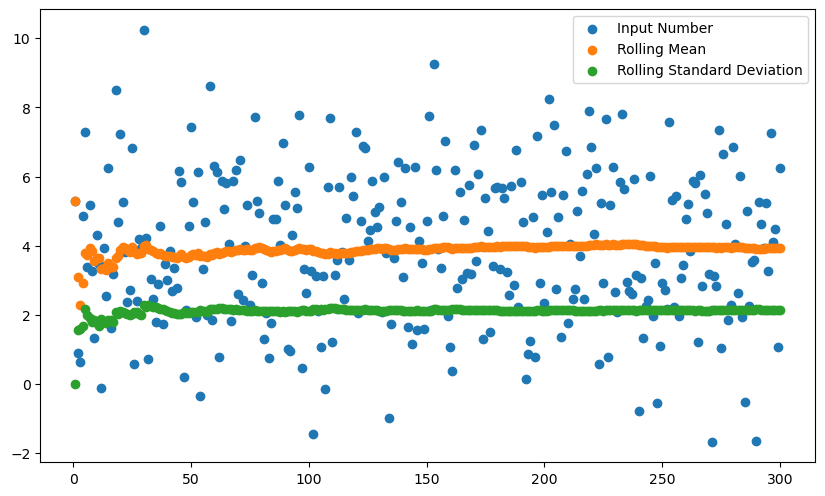

set mean:  4
empiric mean:  3.931806047567463
set standard deviation:  2
empiric standard deviation:  2.144282697578641


In [142]:
# Define a function that takes 1 instance of new input and re-calculates the mean, standard deviation, and instance count
def update_mean_and_stdev(new_input, instance_count, mean, stdev):
    
    # Re-calculate the mean, standard deviation, and instance count based on new input
    mean = (mean*instance_count+new_input)/(instance_count+1)
    stdev = (((new_input-mean)**2+instance_count*(stdev**2))/(instance_count+1))**0.5
    instance_count += 1

    return instance_count, mean, stdev 

# Initiate variables and lists
instance_count = 0
mean = 0
stdev = 0

# Create lists to plot inputs and rolling stats
input_list = []
mean_list = []
stdev_list = []
instance_count_list = []

# Set randomization parameters
randomization_mean = 4
randomization_standard_deviation = 2

start_time = time.time()

# Create input data
for i in range(0,300):
    new_input = random.gauss(randomization_mean, randomization_standard_deviation)
    
    # Re-calculate the mean and standard deviation based on new input
    instance_count, mean, stdev = update_mean_and_stdev(new_input, instance_count, mean, stdev)
    
    # Add updated data to lists  
    instance_count_list.append(instance_count)
    input_list.append(new_input)
    mean_list.append(mean)
    stdev_list.append(stdev)

print("Runtime:", time.time() - start_time, "seconds")
    
# Plot the inputs and rolling stats to see how they converge on the truth
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':100})
plt.scatter(x=instance_count_list, y=input_list, label='Input Number')
plt.scatter(x=instance_count_list, y=mean_list, label='Rolling Mean')
plt.scatter(x=instance_count_list, y=stdev_list, label='Rolling Standard Deviation')
plt.legend()
plt.show()

print("set mean: ", randomization_mean)
print("empiric mean: ", mean)
print('set standard deviation: ', randomization_standard_deviation)
print('empiric standard deviation: ', stdev)

Performance review:  
A gaussian randomizer was used with a set mean of 4 and a set standard deviation of 2. 

|Instance Count|Empiric Mean|Runtime (seconds)|
|---|---|---|
|30,000,000|3.999538916165856|40.576589822769165|
|3,000,000|4.000265949456373|4.189908981323242|
|300,000|3.994657899896193|0.4046919345855713|
|30,000|3.990386795032241|0.04983830451965332|
|3,000|4.017868892768875|0.010398626327514648|
|300|4.087733983773108|0.00048422813415527344|
|30|3.7447370075822315|0.0001590251922607422|
|3|4.345912476661304|0.00012159347534179688|